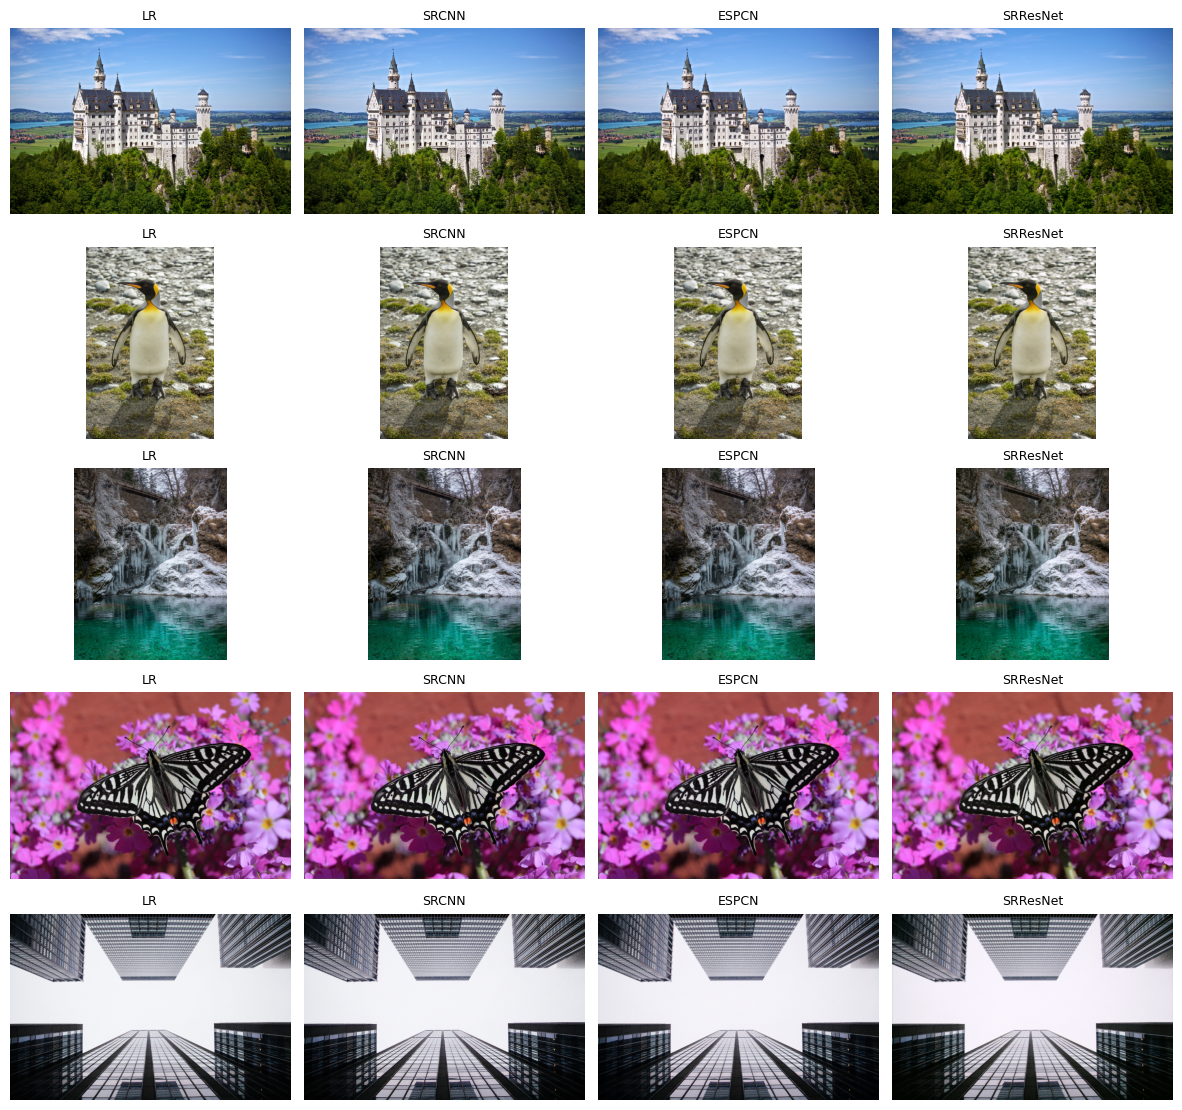

In [21]:
import os
import random
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(3, 64, 9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, 1, padding=0)
        self.layer3 = nn.Conv2d(32, 3, 5, padding=2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

class ESPCN(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.layer1 = nn.Conv2d(3, 64, 5, padding=2)
        self.layer2 = nn.Conv2d(64, 32, 3, padding=1)
        self.layer3 = nn.Conv2d(32, 3 * scale * scale, 3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        x = self.pixel_shuffle(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64)
        )
    def forward(self, x):
        return x + self.block(x)

class UpsampleBlock(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(64, 64 * scale * scale, 3, padding=1),
            nn.PixelShuffle(scale),
            nn.PReLU()
        )
    def forward(self, x):
        return self.block(x)

class SRResNet(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 9, padding=4)
        self.prelu = nn.PReLU()
        self.res_blocks = nn.Sequential(*[ResidualBlock() for _ in range(16)])
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.upsample = UpsampleBlock(scale)
        self.conv3 = nn.Conv2d(64, 3, 9, padding=4)
    def forward(self, x):
        x1 = self.prelu(self.conv1(x))
        x = self.res_blocks(x1)
        x = self.bn2(self.conv2(x))
        x = x + x1
        x = self.upsample(x)
        x = self.conv3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scale = 2

srcnn = SRCNN().to(device)
espcn = ESPCN(scale).to(device)
srresnet = SRResNet(scale).to(device)

srcnn.load_state_dict(torch.load(r"D:\DL Project\srcnn_epoch20.pth"))
espcn.load_state_dict(torch.load(r"D:\DL Project\espcn_epoch20.pth"))
srresnet.load_state_dict(torch.load(r"D:\DL Project\srresnet_epoch20.pth"))

srcnn.eval()
espcn.eval()
srresnet.eval()

lr_folder = r"D:\DL Project\DIV2K_valid_LR_x2"
files = sorted(os.listdir(lr_folder))
sample_files = random.sample(files, 5)

to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

plt.figure(figsize=(15, 14))

for row, filename in enumerate(sample_files):
    lr_img = Image.open(os.path.join(lr_folder, filename)).convert("RGB")
    lr_tensor = to_tensor(lr_img).unsqueeze(0).to(device)

    with torch.no_grad():
        out_srcnn = srcnn(lr_tensor)
        out_espcn = espcn(lr_tensor)
        out_srres = srresnet(lr_tensor)

    out_srcnn = to_pil(out_srcnn.squeeze(0).cpu().clamp(0,1))
    out_espcn = to_pil(out_espcn.squeeze(0).cpu().clamp(0,1))
    out_srres = to_pil(out_srres.squeeze(0).cpu().clamp(0,1))

    plt.subplot(5, 4, row*4+1); plt.imshow(lr_img); plt.title("LR", fontsize=9); plt.axis("off")
    plt.subplot(5, 4, row*4+2); plt.imshow(out_srcnn); plt.title("SRCNN", fontsize=9); plt.axis("off")
    plt.subplot(5, 4, row*4+3); plt.imshow(out_espcn); plt.title("ESPCN", fontsize=9); plt.axis("off")
    plt.subplot(5, 4, row*4+4); plt.imshow(out_srres); plt.title("SRResNet", fontsize=9); plt.axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.show()
